In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
import os
print('CWD is',os.getcwd())
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False
from PIL import Image
import cv2
import keras
from keras import applications
from keras.preprocessing import image
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

CWD is C:\Users\varis



In [7]:
def load_data():
    train = pd.read_csv(r"C:\Users\varis\Downloads\aptos2019-blindness-detection\train.csv")
    test = pd.read_csv(r"C:\Users\varis\Downloads\aptos2019-blindness-detection\test.csv")
    
    train_dir = os.path.join(r"C:\Users\varis\Downloads\aptos2019-blindness-detection\train_images")
    test_dir = os.path.join(r"C:\Users\varis\Downloads\aptos2019-blindness-detection\test_images")
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))
    
    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train,test

df_train,df_test = load_data()
print(df_train.shape,df_test.shape,'\n')
df_train.head(6)

(3662, 4) (1928, 3) 



id_code diagnosis                                          file_path  \
0  000c1434d8d7         2  C:\Users\varis\Downloads\aptos2019-blindness-d...   
1  001639a390f0         4  C:\Users\varis\Downloads\aptos2019-blindness-d...   
2  0024cdab0c1e         1  C:\Users\varis\Downloads\aptos2019-blindness-d...   
3  002c21358ce6         0  C:\Users\varis\Downloads\aptos2019-blindness-d...   
4  005b95c28852         0  C:\Users\varis\Downloads\aptos2019-blindness-d...   
5  0083ee8054ee         4  C:\Users\varis\Downloads\aptos2019-blindness-d...   

          file_name  
0  000c1434d8d7.png  
1  001639a390f0.png  
2  0024cdab0c1e.png  
3  002c21358ce6.png  
4  005b95c28852.png  
5  0083ee8054ee.png

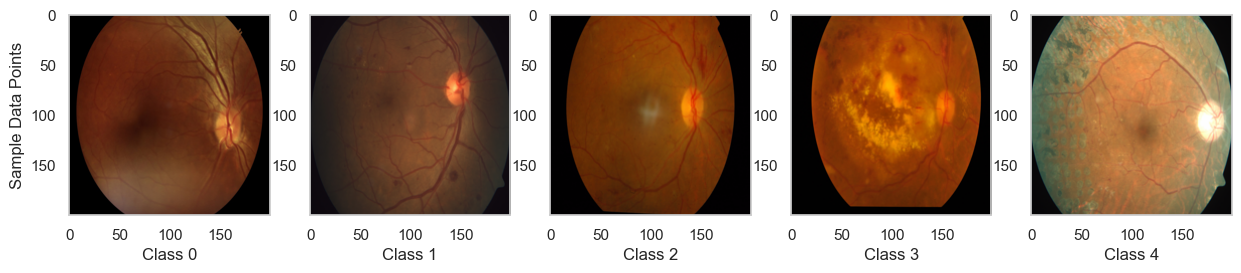

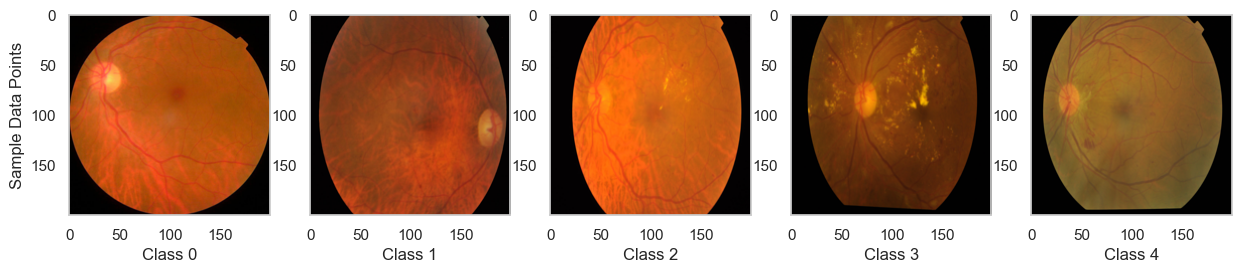

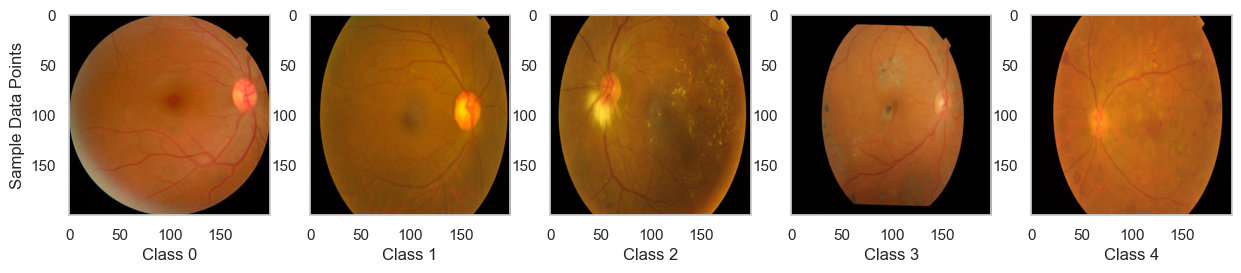

In [8]:
IMG_SIZE = 200

def conv_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    return img

def visualize_imgs(df,pts_per_class,color_scale):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = conv_gray(cv2.imread(df_temp.file_path.iloc[i]))
                axarr[i].imshow(img,cmap = color_scale)
            else:
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((IMG_SIZE,IMG_SIZE)))
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()
        
visualize_imgs(df_train,3,color_scale = None)

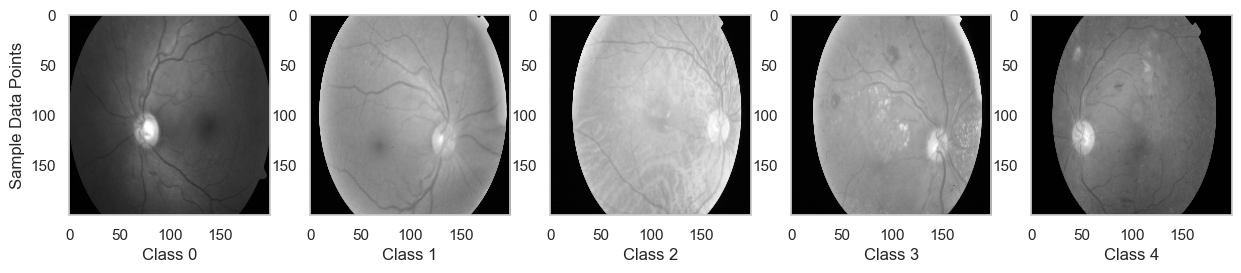

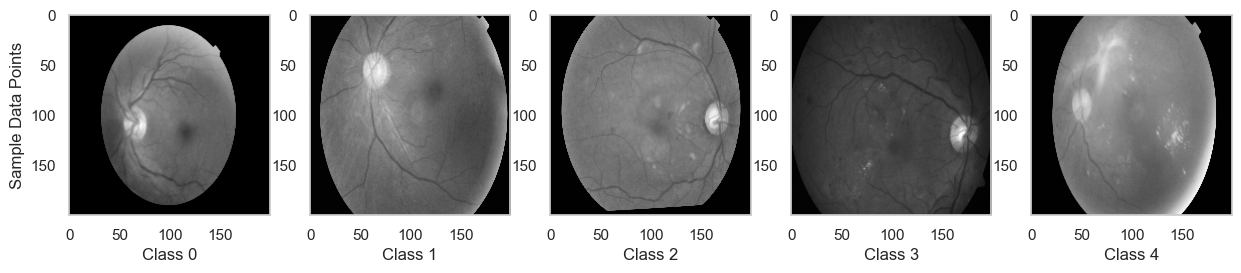

In [9]:
visualize_imgs(df_train,2,color_scale = 'gray')

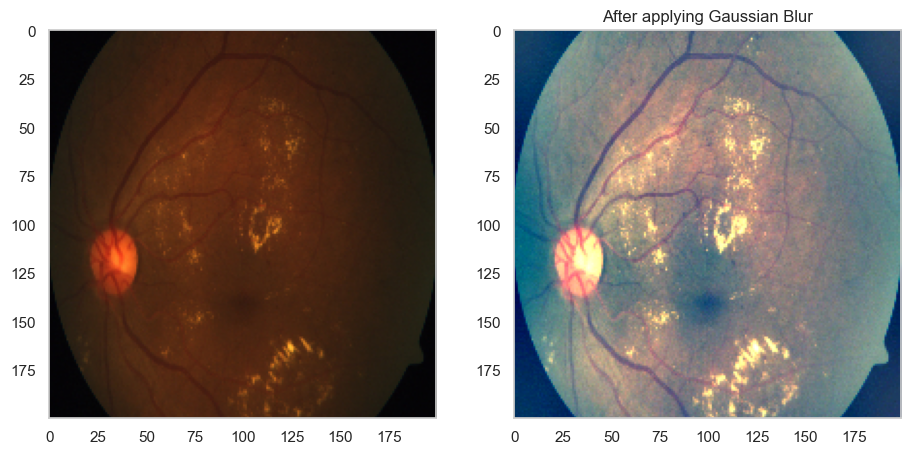

In [10]:
rn = np.random.randint(low = 0,high = len(df_train) - 1)

img = cv2.imread(df_train.file_path.iloc[rn])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

img_t = cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , 30) ,-4 ,128)

f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(img)
axarr[1].imshow(img_t)
plt.title('After applying Gaussian Blur')
plt.show()

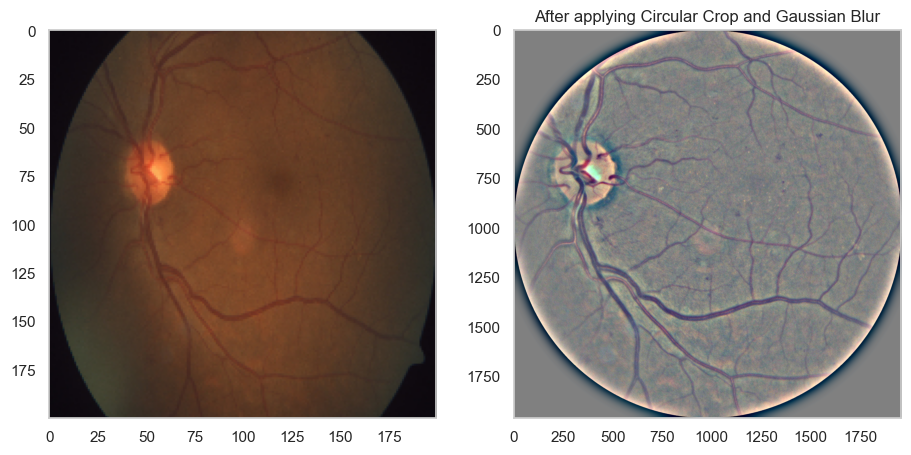

In [11]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
    
def circle_crop(img, sigmaX):   
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

rn = np.random.randint(low = 0,high = len(df_train) - 1)
img = cv2.imread(df_train.file_path.iloc[rn])
img_t = circle_crop(img,sigmaX = 30)

f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),(IMG_SIZE,IMG_SIZE)))
axarr[1].imshow(img_t)
plt.title('After applying Circular Crop and Gaussian Blur')
plt.show()

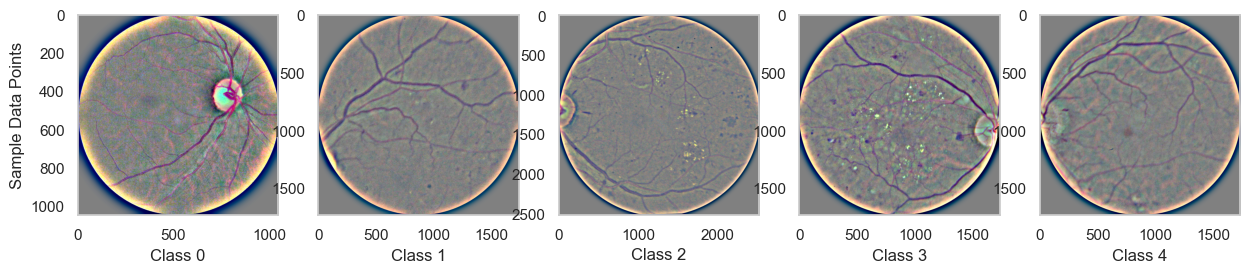

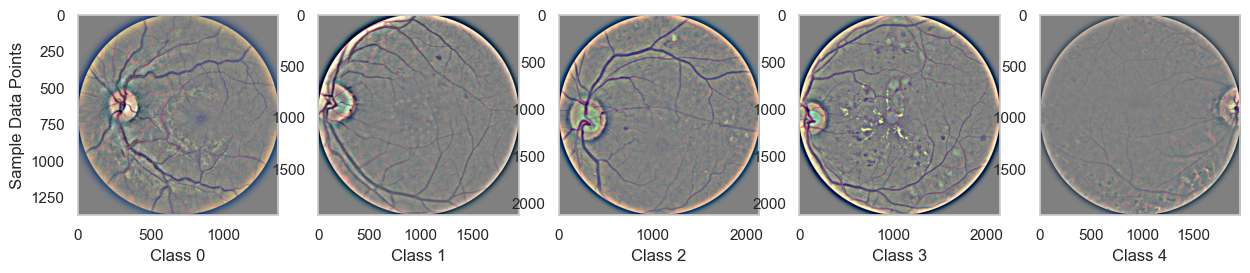

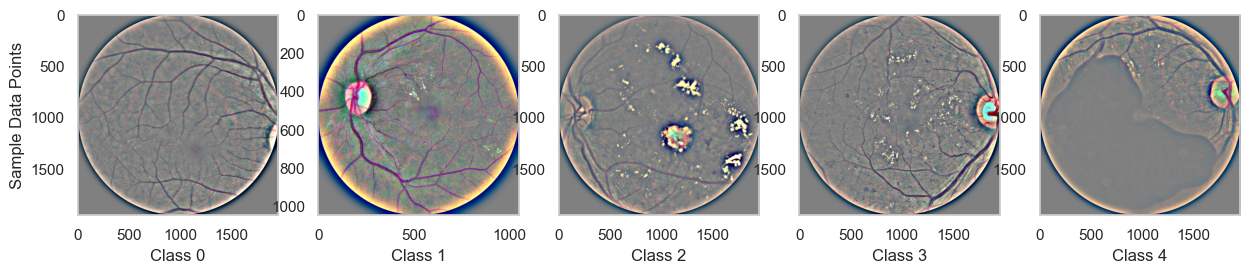

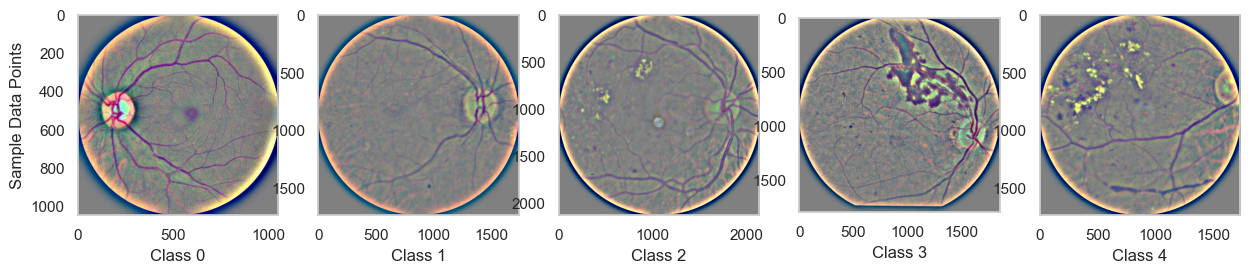

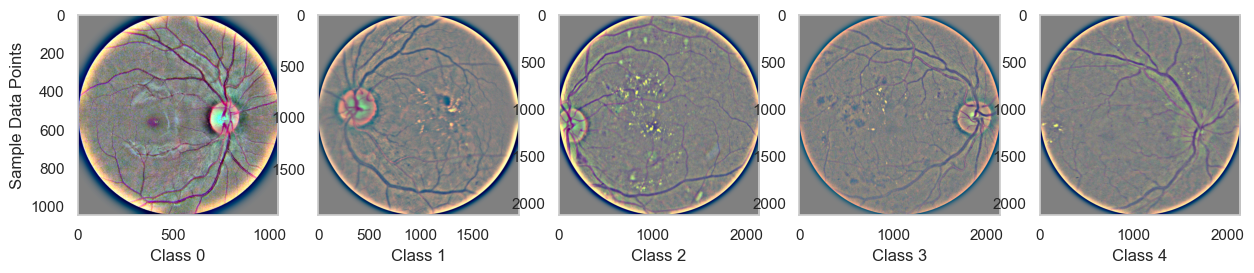

In [13]:
def visualize_img_process(df,pts_per_class,sigmaX):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            img = cv2.imread(df_temp.file_path.iloc[i])
            img = circle_crop(img,sigmaX)
            axarr[i].imshow(img)
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()
        
visualize_img_process(df_train,5,sigmaX = 30)

In [14]:
npix = 224
X_train = np.zeros((df_train.shape[0], npix, npix))
for i in tqdm_notebook(range(df_train.shape[0])):
    img = cv2.imread(df_train.file_path.iloc[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    X_train[i, :, :] = cv2.resize(img, (npix, npix))    
print("X_train shape: " + str(np.shape(X_train))) 

  0%|          | 0/3662 [00:00<?, ?it/s]

X_train shape: (3662, 224, 224)


In [15]:
X = X_train / 255

# reshape
X = X.reshape(X.shape[0], -1)
trainy = df_train['diagnosis']

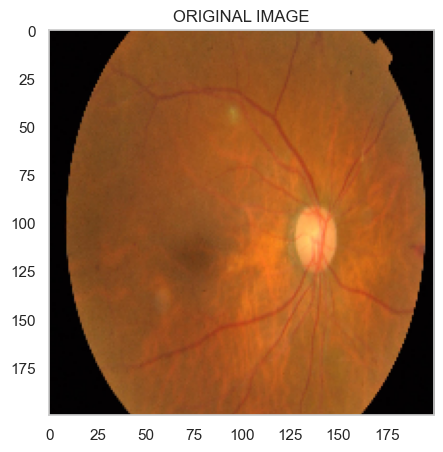

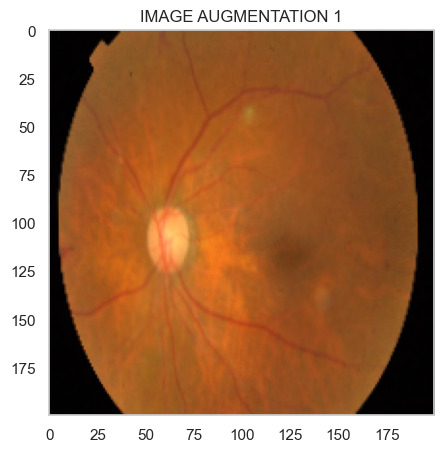

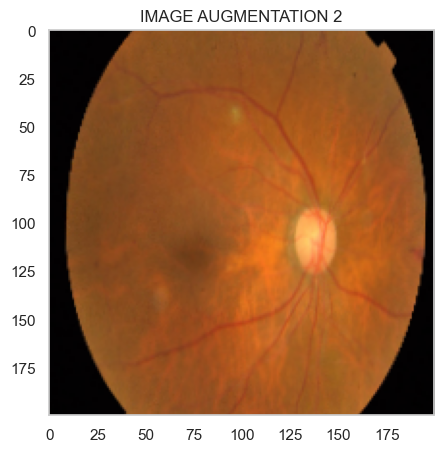

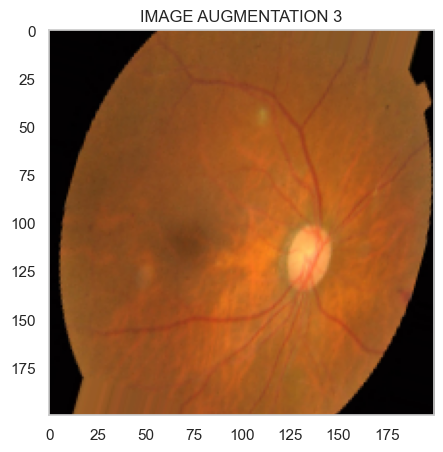

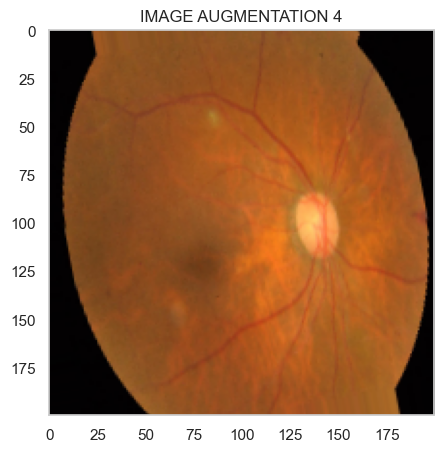

In [16]:
from keras.preprocessing.image import ImageDataGenerator
def generate_augmentations(lim):
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=20,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 horizontal_flip=True)
    img = cv2.imread(df_train.file_path.iloc[np.random.randint(low = 0,high = len(df_train) - 1)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.title('ORIGINAL IMAGE')
    plt.show()
    
    img_arr = img.reshape((1,) + img.shape)
    
    i = 0
    for img_iterator in datagen.flow(x = img_arr,batch_size = 1):
        i = i + 1
        if i > lim:
            break
        plt.imshow((img_iterator.reshape(img_arr[0].shape)).astype(np.uint8))
        plt.title('IMAGE AUGMENTATION ' + str(i))
        plt.show() 
generate_augmentations(4)

In [18]:
df_train_train = df_train.sample(frac=0.8, random_state=42)
df_train_valid = df_train.drop(df_train_train.index)

train_images_dir = r"C:\Users\varis\Downloads\aptos2019-blindness-detection\train_images"
train_dir = './train_images_split'
valid_dir = './valid_images_split'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

for index, row in df_train_train.iterrows():
    src = os.path.join(train_images_dir, row['file_name'])
    dst = os.path.join(train_dir, row['file_name'])
    shutil.copy(src, dst)

for index, row in df_train_valid.iterrows():
    src = os.path.join(train_images_dir, row['file_name'])
    dst = os.path.join(valid_dir, row['file_name'])
    shutil.copy(src, dst)

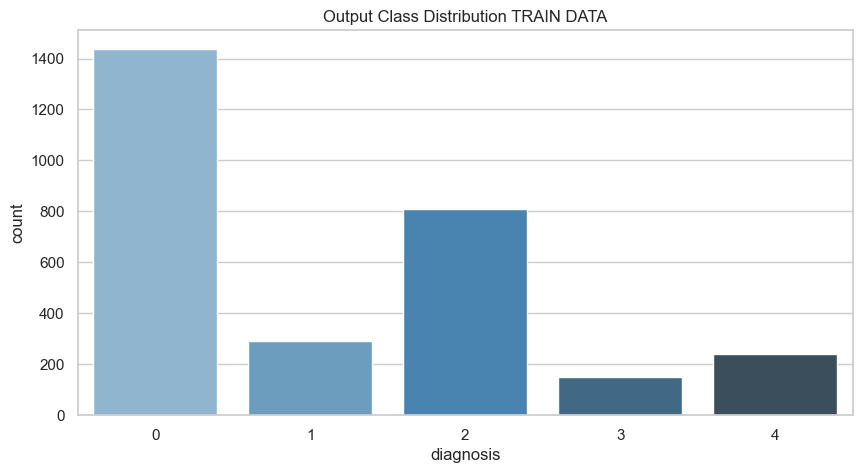

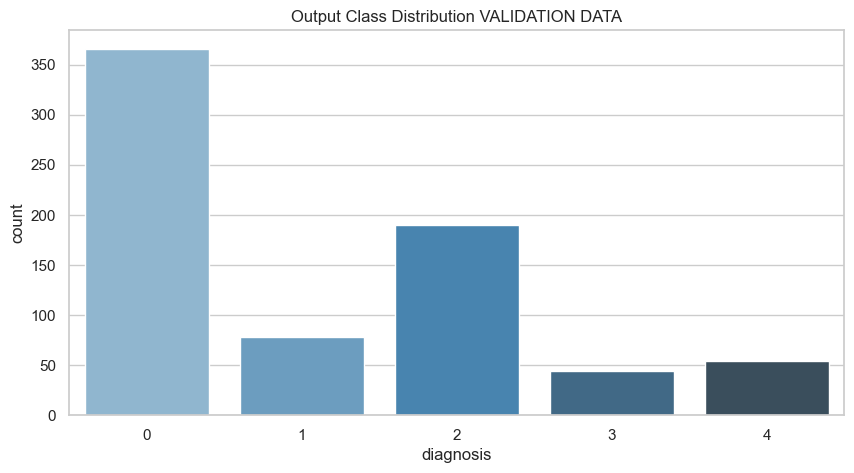

In [19]:
def plot_classes(df,title):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution ' + str(title))
    plt.show() 
    
    
plot_classes(df_train_train,"TRAIN DATA")
plot_classes(df_train_valid,'VALIDATION DATA')

In [20]:
file = open('df_train_train', 'wb')
pickle.dump(df_train_train, file)
file.close()

file = open('df_train_valid', 'wb')
pickle.dump(df_train_valid, file)
file.close()

In [22]:
IMG_SIZE  = 512
def image_resize_save(file):
    input_filepath = os.path.join(r"C:\Users\varis\Downloads\aptos2019-blindness-detection\train_images",'{}.png'.format(file))
    output_filepath = os.path.join('./valid_images_split','{}.png'.format(file))
    img = cv2.imread(input_filepath)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))
image_resize_save(df_train.id_code.iloc[201])

In [24]:
import concurrent.futures

def multiprocess_image_downloader(process: int, imgs: list):
    print(f'MESSAGE: Running {process} process')
    with concurrent.futures.ThreadPoolExecutor(max_workers=process) as executor:
        results = list(executor.map(image_resize_save, imgs))
    return results

multiprocess_image_downloader(6, list(df_train_valid.id_code.values))


MESSAGE: Running 6 process


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [45]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def circle_crop(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def preprocess_image(file):
    input_filepath = os.path.join('/kaggle/input/aptos2019-blindness-detection/train_images','{}.png'.format(file))
    output_filepath = os.path.join('/kaggle/working/valid_images_split','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

In [56]:
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = df_train_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

def img_generator(train, test):
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, horizontal_flip=True)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train_train,
        directory='./train_images_split',
        x_col="file_name",
        y_col="diagnosis",
        batch_size=BATCH_SIZE,
        class_mode="categorical", 
        target_size=(HEIGHT, WIDTH)
    )

    valid_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train_valid,
        directory='./valid_images_split',
        x_col="file_name",
        y_col="diagnosis",
        batch_size=BATCH_SIZE,
        class_mode="categorical", 
        target_size=(HEIGHT, WIDTH)
    )

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=r"C:\Users\varis\Downloads\aptos2019-blindness-detection\test_images",
        x_col="file_name",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None
    )

    return train_generator, valid_generator, test_generator

train_generator, valid_generator, test_generator = img_generator(df_train_train, df_train_valid)


Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Constants
BATCH_SIZE = 16
EPOCHS = 5
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 224
WIDTH = 224
CANAL = 3
N_CLASSES = df_train_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

# Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    if epoch < WARMUP_EPOCHS:
        return WARMUP_LEARNING_RATE
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = LearningRateScheduler(lr_scheduler)

# MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, CANAL))

# Build the model
model = models.Sequential([
    base_model,
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(N_CLASSES, activation='softmax')
])

# Fine-tune more layers
for layer in model.layers[0].layers[:-10]:
    layer.trainable = True

# Compile the model
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

# Image Generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train_train,
    directory='./train_images_split',
    x_col="file_name",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset="training"
)

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train_train,
    directory='./train_images_split',
    x_col="file_name",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset="validation"
)


class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))


# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    class_weight=class_weight_dict,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=DECAY_DROP, patience=RLROP_PATIENCE, verbose=1), lr_callback]
)

# Save the trained model
model.save(r'C:\Users\varis\Downloads\aptos2019-blindness-detection\diabetic_retinopathy_model.h5')


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d_25 (Conv2D)          (None, 7, 7, 512)         5898752   
                                                                 
 conv2d_26 (Conv2D)          (None, 7, 7, 512)         2359808   
                                                                 
 conv2d_27 (Conv2D)          (None, 7, 7, 256)         1179904   
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 3, 3, 256)         0         
 ng2D)                                                           
                                                                 
 global_average_pooling2d_2  (None, 256)             

In [90]:
trained_model = models.load_model(r'C:\Users\varis\Downloads\aptos2019-blindness-detection\diabetic_retinopathy_model.h5')
image_path = r"C:\Users\varis\Downloads\aptos2019-blindness-detection\train_images\fecf4c5ae84b.png"
img = image.load_img(image_path, target_size=(HEIGHT, WIDTH))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0
predictions = trained_model.predict(img_array)
predicted_label = np.argmax(predictions)
class_mapping = {
    0: "No DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative DR"
}
predicted_class = class_mapping[predicted_label]
print(f"Predicted class index: {predicted_label}")
print(f"Predicted class name: {predicted_class}")


1/1 [==============================] - 1s 927ms/step
Predicted class index: 0
Predicted class name: No DR
